In [81]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
sys.path.append('/home/manu/TFG_repo/scripts')  # make modules in scripts folder callable from notebooks

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [86]:
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
from numba import njit, prange
import multiprocessing as mp

In [100]:
from analysis_routines import * 
from utide import solve
from ploting_routines import *
plt.style.use('/home/manu/TFG_repo/notebooks/notebook.mplstyle')

In [4]:
temp, pres, date = load_time_series('processed/AGL_20181116_chain.nc')

In [311]:
import xarray
data = xarray.open_dataset(data_dir / 'time_series' / 'processed' / 'AGL_20181116_chain_xrcompatible.nc', mask_and_scale=True)
data['date'] = pd.to_datetime(xr['date'], unit='s')

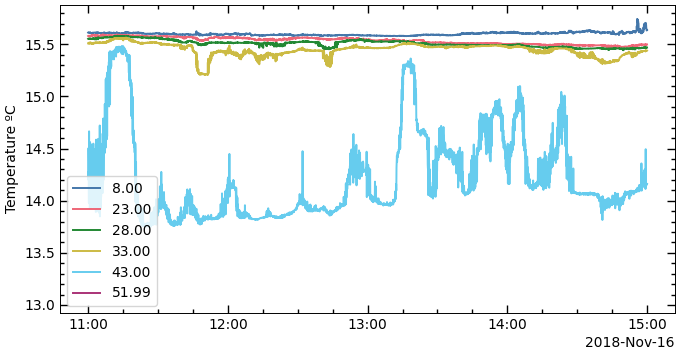

In [325]:
def plot_thermistor_temperature(data, idxs, wide='True', lims=[None, None], interval=None):
    '''Plot a single thermistor temperature series 
    '''
    locator = mdates.AutoDateLocator(minticks=3, maxticks=7)
    formatter = mdates.ConciseDateFormatter(locator)

    if wide:
        fig, ax = plt.subplots(figsize=(7, 3.75))
    else: 
        fig, ax = plt.subplots()

    slice_ = slice(lims[0], lims[1], interval)
    
    ax.xaxis.set_major_locator(locator)
    ax.xaxis.set_major_formatter(formatter)
    if isinstance(idxs, list):
        for i in idxs:
            data_i = data.isel(depth=i).sel(date=slice_)
            date_i = data_i.date
            temp_i = data_i.temp
            depth_i = float(data_i.meassured_depth[0])
            ax.plot(date_i, temp_i, label='{:.2f}'.format(depth_i))
            ax.legend()
            ax.set_ylabel('Temperature ºC')

    else:
        i = idxs
        if isinstance(temp, np.ma.core.MaskedArray):
            date_i = date[temp[:, i].mask==False]
            temp_i = if_masked_to_array(temp[:, i])

            if isinstance(lims[0], datetime):
                lims[0] = date_to_idx(date_i, lims[0])

            if isinstance(lims[1], datetime):
                lims[1] = date_to_idx(date_i, lims[1])

            if isinstance(interval, timedelta):
                interval = timedelta_to_interval(interval)

            date_i = date_i[lims[0]:lims[1]:interval]
            temp_i = temp_i[lims[0]:lims[1]:interval]

            ax.plot(date_i, temp_i)
            ax.set_title(f'Temperature at depth {depth[0, i]} db (ºC)')
    fig.tight_layout()
    plt.show()

plot_thermistor_temperature(data, [1, 2, 3, 4, 5, 6], lims=[datetime(2018, 11, 16, 11), datetime(2018, 11, 16, 15)])

In [233]:
print(a.sel(date=slice(datetime(2018, 11, 16), datetime(2018,11,17))))

TypeError: '<' not supported between instances of 'int' and 'datetime.datetime'

In [5]:
df_ci = load_SHDR_fit('optimal_server_fit/AGL_20181116_fit_fci.csv')
df_c = load_SHDR_fit('optimal_server_fit/AGL_20181116_fit_fc.csv')
df_s = load_SHDR_fit('optimal_server_fit/AGL_20181116_fit_s.csv')

1          36.060161
2          38.437575
3          37.281257
4          32.680803
5          39.368609
             ...    
2471035    16.565328
2471036    16.336121
2471037    16.236786
2471038    15.790006
2471039    15.792467
Name: D1, Length: 2471039, dtype: float64

In [6]:
em_ci = np.load(data_dir / 'SHDR_fit/aux/AGL_20181116_ci_fit_real_em.npy')
mld_thresh_i_02 = np.load(data_dir / 'SHDR_fit/aux/02_threshold_i_20181116.npy')

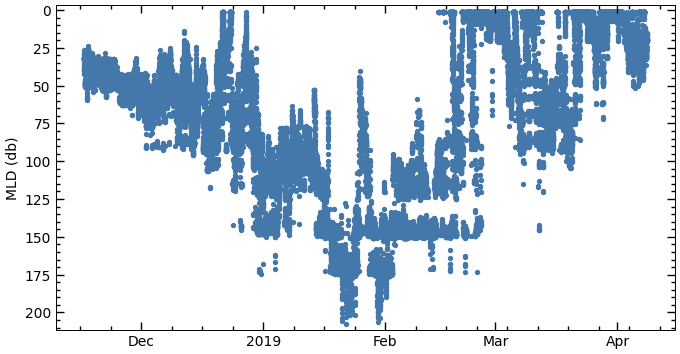

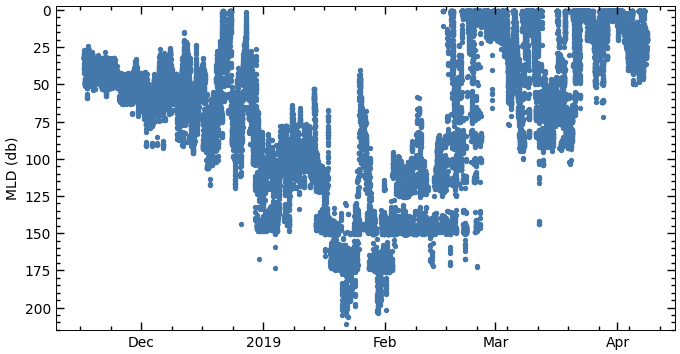

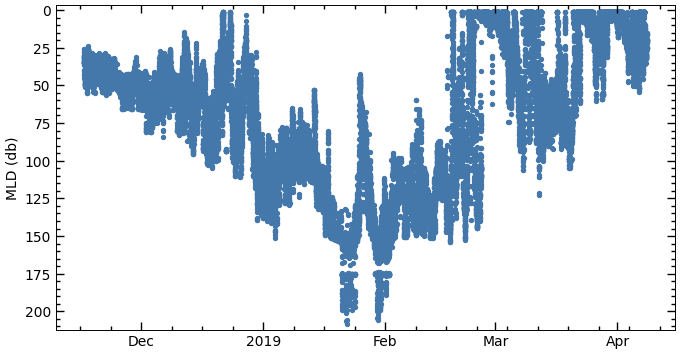

In [101]:
plot_fit_variable(df_s, 'D1', interval=timedelta(minutes=5))
plot_fit_variable(df_c, 'D1', interval=timedelta(minutes=5))
plot_fit_variable(df_ci, 'D1', interval=timedelta(minutes=5))

### Distance


In [7]:
locs_5_s, ratio_5_s = distance(df_s, 'D1', 1, 5)
locs_10_s, ratio_10_s = distance(df_s, 'D1', 1, 10)
locs_15_s, ratio_15_s = distance(df_s, 'D1', 1, 15)
locs_5_c, ratio_5_c = distance(df_c, 'D1', 1, 5)
locs_10_c, ratio_10_c = distance(df_c, 'D1', 1, 10)
locs_15_c, ratio_15_c = distance(df_c, 'D1', 1, 15)
locs_5_ci, ratio_5_ci = distance(df_ci, 'D1', 1, 5)
locs_10_ci, ratio_10_ci = distance(df_ci, 'D1', 1, 10)
locs_15_ci, ratio_15_ci = distance(df_ci, 'D1', 1, 15)

ratios_5 = np.array([ratio_5_s, ratio_5_c, ratio_5_ci])*100
ratios_10 = np.array([ratio_10_s, ratio_10_c, ratio_10_ci])*100
ratios_15 = np.array([ratio_15_s, ratio_15_c, ratio_15_ci])*100

In [8]:
D1_s = df_s['D1'].to_numpy()
D1_c = df_c['D1'].to_numpy()
D1_ci = df_ci['D1'].to_numpy()

distances_10_s = D1_s[locs_10_s + 1] - D1_s[locs_10_s]
date_s = date[locs_10_s]

distances_10_c = D1_c[locs_10_c + 1] - D1_c[locs_10_c]
date_c = date[locs_10_c]

distances_10_ci = D1_ci[locs_10_ci + 1] - D1_ci[locs_10_ci]
date_ci = date[locs_10_ci]

def plot_distances(df, variable, locs, lims=[None, None]):

    if isinstance(lims[0], datetime):
        lims[0] = date_to_idx(df['date'], lims[0])
    
    if isinstance(lims[1], datetime):
        lims[1] = date_to_idx(df['date'], lims[1])
        
    locator = mdates.AutoDateLocator(minticks=3, maxticks=7)
    formatter = mdates.ConciseDateFormatter(locator)
    
    
    i_0 = np.searchsorted(locs, lims[0])
    i_f = np.searchsorted(locs, lims[1])
    locs = locs[i_0:i_f]
    arr_variable = df[variable].to_numpy()
    distances = arr_variable[locs + 1] - arr_variable[locs] 
    date_d = df['date'].to_numpy()[locs]
    
    fig, ax = plt.subplots(figsize=(7, 3.75))
    ax.xaxis.set_major_locator(locator)
    ax.xaxis.set_major_formatter(formatter)

    ax.scatter(date_d, distances)
    fig.tight_layout()
    plt.show()

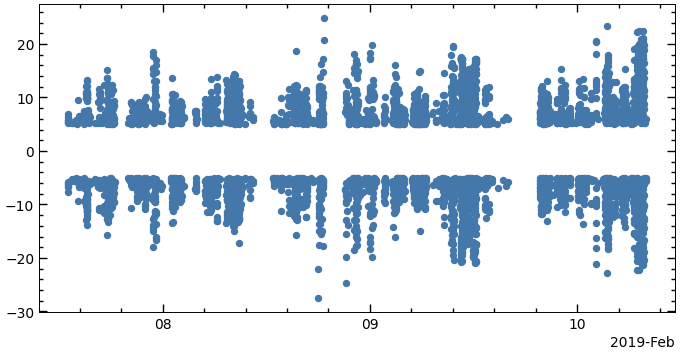

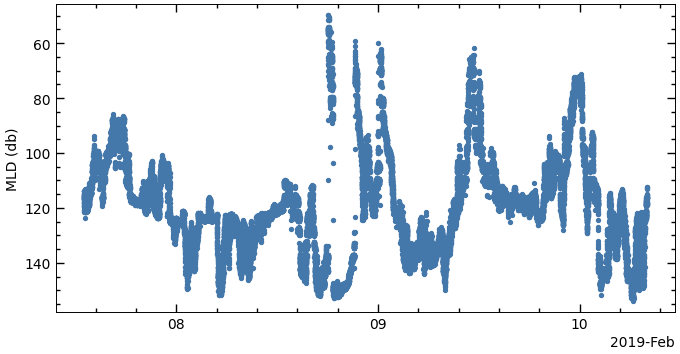

In [175]:
date_0 = datetime(2019, 2, 7, 13)
date_1 = datetime(2019, 2, 10, 8)
plot_distances(df_ci, 'D1', locs_5_ci, lims=[date_0, date_1])
#density_plot(date_ci, np.abs(distances_ci), lims=[date_0, date_1])    
plot_fit_variable(df_ci, 'D1', lims=[date_0, date_1])

In [171]:
def density_plot(date, variable, levels=100, lims=[None, None]):
    if isinstance(lims[0], datetime):
        lims[0] = date_to_idx(date, lims[0])

    if isinstance(lims[1], datetime):
        lims[1] = date_to_idx(date, lims[1])

    date = date[lims[0]:lims[1]]
    variable = variable[lims[0]:lims[1]]
    fig, ax = plt.subplots(figsize=(7, 3.75))
    ax = sns.kdeplot(x=date, y=variable, fill=True, levels=levels, cmap='viridis')
    locator = mdates.AutoDateLocator(minticks=3, maxticks=7)
    formatter = mdates.ConciseDateFormatter(locator)
    
    ax.xaxis.set_major_locator(locator)
    ax.xaxis.set_major_formatter(formatter)
    fig.tight_layout()
    plt.show()

    
density_plot(date_ci, np.abs(distances_ci))    


NameError: name 'distances_ci' is not defined

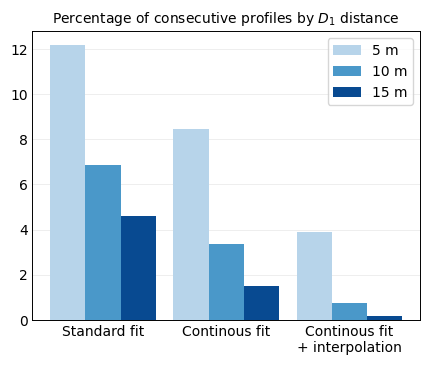

In [131]:
fig, ax = plt.subplots()
x = np.array([0, 1.4, 2.8])
bar_width = 0.4
colors = plt.cm.Blues(np.linspace(0.3, 0.9, 3))
b1 = ax.bar(x, ratios_5, width=bar_width, label='5 m', color=colors[0])
b2 = ax.bar(x + bar_width, ratios_10, width=bar_width, label='10 m', color=colors[1])
b3 = ax.bar(x + bar_width*2, ratios_15, width=bar_width, label='15 m', color=colors[2])
ax.tick_params(which='both', bottom=False, left=False, right=False, top=False)
ax.set_axisbelow(True)
ax.set_xticks(x + bar_width)
ax.set_xticklabels(['Standard fit', 'Continous fit', 'Continous fit\n+ interpolation'])
ax.yaxis.grid(True, color='#EEEEEE')
ax.xaxis.grid(False)
ax.legend()
ax.set_title('Percentage of consecutive profiles by $D_1$ distance')
plt.show()

In [156]:
em_smaller_ci = np.where(em_ci < df_s['em'])[0]
isolated_locs_5_s = locs_5_s[:-1][(locs_5_s[1:] - locs_5_s[:-1] != 1)]
print(len(isolated_locs_5_s)/len(locs_5_s))
distance_smaller_ci = locs_15_s[(np.in1d(locs_15_s, locs_15_ci) == False)]
distance_smaller_and_em_smaller = np.where(np.in1d(em_smaller_ci, distance_smaller_ci) == True)[0]
print(len(distance_smaller_and_em_smaller)/len(em_smaller_ci))
em_s = df_s['em'].to_numpy()
em_jumps_s = np.where(em_s[1:] - em_s[:-1] > em_s.std())[0]
ratio_em_jumps_s_better_ci = len(np.where(np.in1d(em_jumps_s+1, em_smaller_ci) == True)[0])/len(em_jumps_s)
print(ratio_em_jumps_s_better_ci)


0.46939976070194095
0.2914584262105321
0.5810348439354793


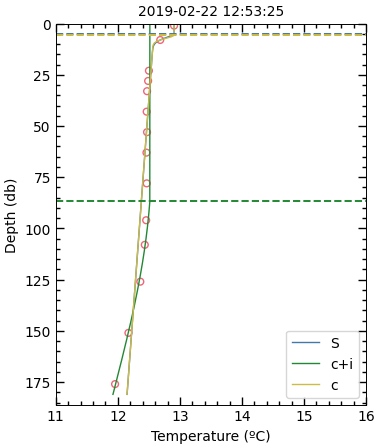

In [165]:
compare_fit_modes_profile(df_s, df_c, df_ci, pres, temp, a)

In [141]:
em_dif_large_s = distance(df_s, 'em', 1, 0.04)[0]
em_bigger_ci = np.where(em_ci - df_s['em'] > em_ci.std())[0]

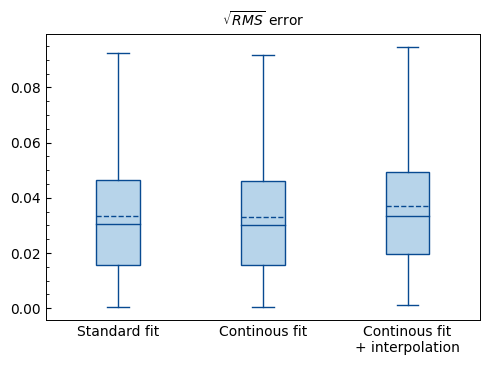

In [11]:
fig, ax = plt.subplots()
colors = plt.cm.Blues(np.linspace(0.3, 0.9, 3))
bp = ax.boxplot([df_s['em'], df_c['em'], em_ci], showfliers=False, patch_artist=True, meanline=True, showmeans=True, 
                boxprops=dict(facecolor=colors[0], color=colors[2]), 
                medianprops=dict(color=colors[2]), 
                meanprops=dict(color=colors[2]),
                capprops=dict(color=colors[2]),
                whiskerprops=dict(color=colors[2]))
                
ax.tick_params(which='both', bottom=False, right=False, top=False)
ax.set_xticklabels(['Standard fit', 'Continous fit', 'Continous fit\n+ interpolation'])
ax.set_title(r'$\sqrt{RMS}$ error')
fig.tight_layout()
plt.show()

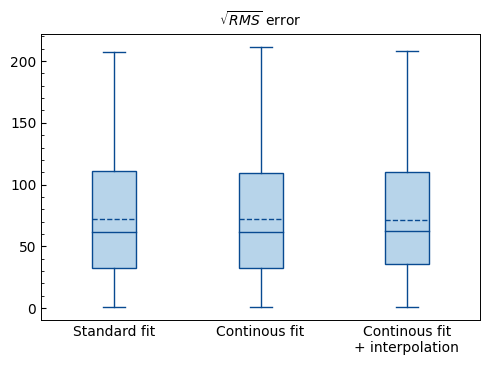

In [13]:
fig, ax = plt.subplots()
colors = plt.cm.Blues(np.linspace(0.3, 0.9, 3))
bp = ax.boxplot([df_s['D1'], df_c['D1'], df_ci['D1']], showfliers=True, patch_artist=True, meanline=True, showmeans=True, 
                boxprops=dict(facecolor=colors[0], color=colors[2]), 
                medianprops=dict(color=colors[2]), 
                meanprops=dict(color=colors[2]),
                capprops=dict(color=colors[2]),
                whiskerprops=dict(color=colors[2]))
                
ax.tick_params(which='both', bottom=False, right=False, top=False)
ax.set_xticklabels(['Standard fit', 'Continous fit', 'Continous fit\n+ interpolation'])
ax.set_title(r'$\sqrt{RMS}$ error')
fig.tight_layout()
plt.show()

In [30]:
s_thrs = abs(df_s['D1'] - mld_thresh_i_02)
c_thrs = abs(df_c['D1'] - mld_thresh_i_02)
ci_thrs = abs(df_ci['D1'] - mld_thresh_i_02)
D1_vs_thrs = [s_thrs, c_thrs, ci_thrs]

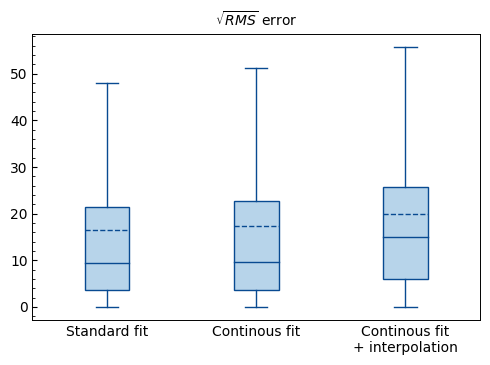

In [33]:
fig, ax = plt.subplots()
colors = plt.cm.Blues(np.linspace(0.3, 0.9, 3))
bp = ax.boxplot(D1_vs_thrs, showfliers=False, patch_artist=True, meanline=True, showmeans=True, 
                boxprops=dict(facecolor=colors[0], color=colors[2]), 
                medianprops=dict(color=colors[2]), 
                meanprops=dict(color=colors[2]),
                capprops=dict(color=colors[2]),
                whiskerprops=dict(color=colors[2]))
                
ax.tick_params(which='both', bottom=False, right=False, top=False)
ax.set_xticklabels(['Standard fit', 'Continous fit', 'Continous fit\n+ interpolation'])
ax.set_title(r'$\sqrt{RMS}$ error')
fig.tight_layout()
plt.show()

In [177]:
QI_ci = np.load(data_dir / 'SHDR_fit' / 'aux' / 'QI_ci_20181116.npy')
QI_ci_i = np.load(data_dir / 'SHDR_fit' / 'aux' / 'QI_ci_i_20181116.npy')
QI_c = np.load(data_dir / 'SHDR_fit' / 'aux' / 'QI_c_20181116.npy')
QI_s = np.load(data_dir / 'SHDR_fit' / 'aux' / 'QI_s_20181116.npy')
QI_s_i = np.load(data_dir / 'SHDR_fit' / 'aux' / 'QI_s_i_20181116.npy')


0.8745855373564131
0.8781039186843932
0.8825600627586061
0.8826279261417992
nan


/tmp/ipykernel_17703/40009313.py:5: RuntimeWarning: Mean of empty slice
  print(np.nanmean(QI_s_i[:1000000]))


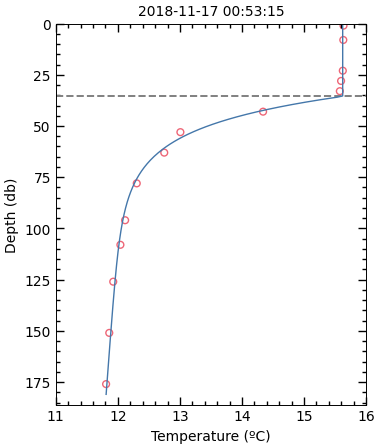

In [178]:
print(np.nanmean(QI_ci[:1000000]))
print(np.nanmean(QI_ci_i[:1000000]))
print(np.nanmean(QI_c[:1000000]))
print(np.nanmean(QI_s[:1000000]))
print(np.nanmean(QI_s_i[:1000000]))


plot_profile_fit(df_ci, temp, pres, 9999)

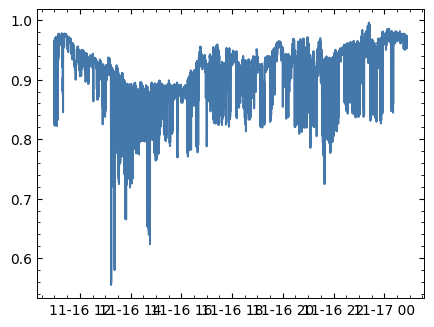

In [14]:
plt.plot(date[:10000], QI_s_i[:10000])